In [1]:
# Step 1: Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# nicer plots
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)

# versions
print("numpy", np.__version__, "pandas", pd.__version__)


numpy 1.26.4 pandas 2.2.2


In [3]:
# Step 2: load
path = "top_goals_clean.csv"
if not os.path.exists(path):
    raise FileNotFoundError(f"{path} not found in current folder: {os.getcwd()}")

top_goals = pd.read_csv(path)
print("top_goals shape:", top_goals.shape)
print("Columns:", top_goals.columns.tolist())
top_goals.head(8)


top_goals shape: (324, 19)
Columns: ['Season', 'Rank', 'Player', 'Club', 'Goals', 'IsTop10', 'Position', 'Age', 'Appearances', 'Goals_prev_season', 'Assists', 'Penalty_Goals', 'Non-Penalty_Goals', 'Goals_per_90', 'Big_6_Club_Feature', 'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match', 'Games_in_Season']


,Season,Rank,Player,Club,Goals,IsTop10,Position,Age,Appearances,Goals_prev_season,Assists,Penalty_Goals,Non-Penalty_Goals,Goals_per_90,Big_6_Club_Feature,Club_League_Rank,Club_Total_Goals,League_Goals_per_Match,Games_in_Season
0,2023-24,1,Erling Haaland,Manchester City,27,1,Forward,23,31,36.0,6.0,1.0,26,0.85,1.0,1,96,2.83,38.0
1,2023-24,2,Cole Palmer,Chelsea,22,1,Attacking Midfielder,22,33,3.0,11.0,9.0,13,0.61,1.0,6,77,2.83,38.0
2,2023-24,3,Alexander Isak,Newcastle United,21,1,Forward,24,30,10.0,2.0,5.0,16,0.76,0.0,7,85,2.83,38.0
3,2023-24,4,Ollie Watkins,Aston Villa,19,1,Forward,28,37,15.0,13.0,0.0,19,0.51,0.0,4,76,2.83,38.0
4,2023-24,4,Dominic Solanke,AFC Bournemouth,19,1,Forward,26,38,6.0,3.0,1.0,18,0.50,0.0,12,54,2.83,38.0
5,2023-24,6,Phil Foden,Manchester City,19,1,Winger,23,35,11.0,8.0,0.0,19,0.54,1.0,1,96,2.83,38.0
6,2023-24,7,Mohamed Salah,Liverpool,18,1,Winger,31,32,19.0,10.0,5.0,13,0.56,1.0,3,86,2.83,38.0
7,2023-24,8,Son Heung-min,Tottenham Hotspur,17,1,Winger,31,35,10.0,10.0,2.0,15,0.49,1.0,5,74,2.83,38.0


In [4]:
# Step 3: overview
print("INFO:")
display(top_goals.info())

print("\nDESCRIBE (numeric):")
display(top_goals.describe().T)

print("\nMissing values per column:")
display(top_goals.isnull().sum().sort_values(ascending=False).head(20))


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Season                  324 non-null    object 
 1   Rank                    324 non-null    int64  
 2   Player                  324 non-null    object 
 3   Club                    324 non-null    object 
 4   Goals                   324 non-null    int64  
 5   IsTop10                 324 non-null    int64  
 6   Position                324 non-null    object 
 7   Age                     324 non-null    int64  
 8   Appearances             324 non-null    int64  
 9   Goals_prev_season       324 non-null    float64
 10  Assists                 324 non-null    float64
 11  Penalty_Goals           324 non-null    float64
 12  Non-Penalty_Goals       324 non-null    int64  
 13  Goals_per_90            324 non-null    float64
 14  Big_6_Club_Feature      324 non-null

None


DESCRIBE (numeric):


,count,mean,std,min,25%,50%,75%,max
Rank,324.0,5.219136,2.770612,1.00,3.00,5.00,7.25,10.0
Goals,324.0,17.688272,4.873481,9.00,14.00,17.00,20.00,36.0
IsTop10,324.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.0
Age,324.0,26.435185,3.409892,18.00,24.00,26.00,29.00,37.0
Appearances,324.0,33.898148,4.442839,13.00,32.00,35.00,37.00,42.0
Goals_prev_season,324.0,9.925926,9.198233,0.00,0.00,10.00,17.00,36.0
Assists,324.0,1.771605,3.379550,0.00,0.00,0.00,2.00,15.0
Penalty_Goals,324.0,0.703704,1.679927,0.00,0.00,0.00,0.00,10.0
Non-Penalty_Goals,324.0,16.932099,4.714284,0.00,14.00,16.00,19.00,34.0
Goals_per_90,324.0,0.577778,0.925862,0.26,0.42,0.50,0.61,17.0



Missing values per column:


Season                    0
Assists                   0
League_Goals_per_Match    0
Club_Total_Goals          0
Club_League_Rank          0
Big_6_Club_Feature        0
Goals_per_90              0
Non-Penalty_Goals         0
Penalty_Goals             0
Goals_prev_season         0
Rank                      0
Appearances               0
Age                       0
Position                  0
IsTop10                   0
Goals                     0
Club                      0
Player                    0
Games_in_Season           0
dtype: int64

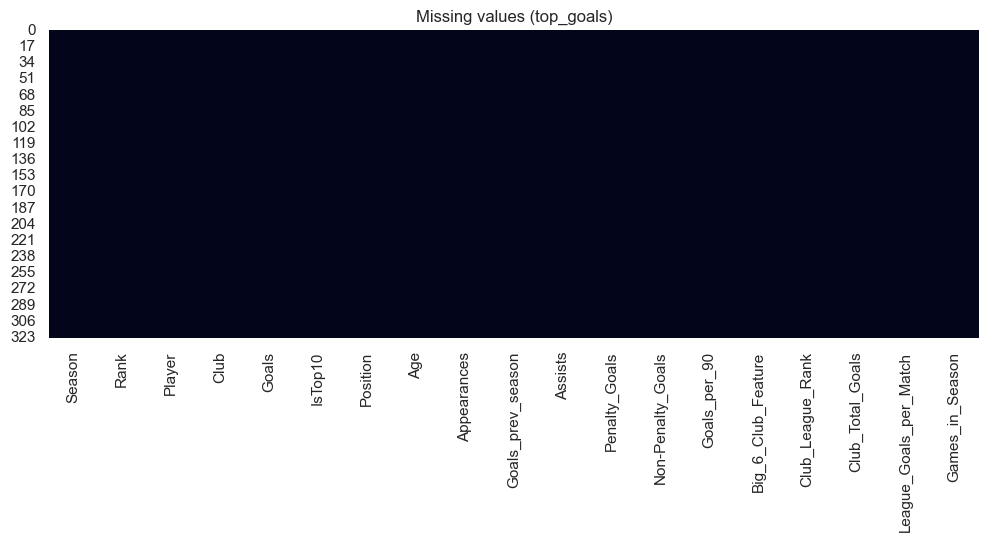

Numeric columns: ['Rank', 'Goals', 'IsTop10', 'Age', 'Appearances', 'Goals_prev_season', 'Assists', 'Penalty_Goals', 'Non-Penalty_Goals', 'Goals_per_90', 'Big_6_Club_Feature', 'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match', 'Games_in_Season']


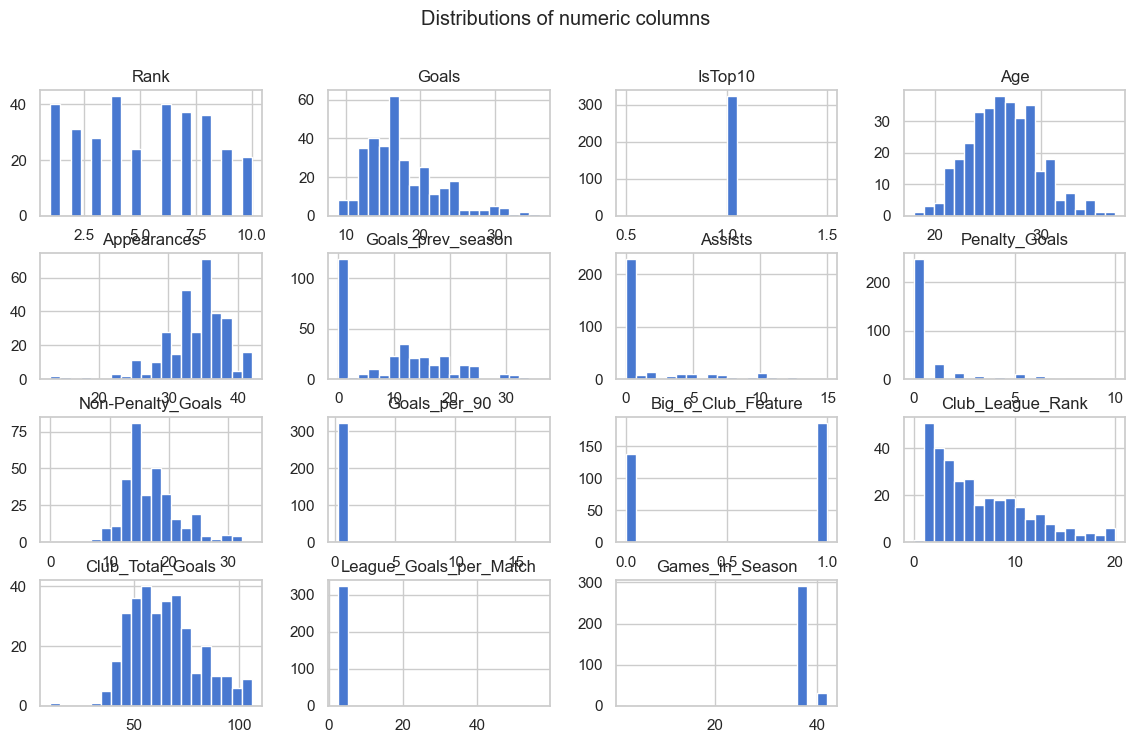

In [5]:
# Step 4: missing heatmap
plt.figure(figsize=(12,4))
sns.heatmap(top_goals.isnull(), cbar=False)
plt.title("Missing values (top_goals)")
plt.show()

# Histograms of numeric columns
numeric_cols = top_goals.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
top_goals[numeric_cols].hist(bins=20, figsize=(14,8))
plt.suptitle("Distributions of numeric columns")
plt.show()


In [6]:
# Step 5: drop irrelevant columns if present
top_goals_clean = top_goals.copy()

# Drop columns that are obviously metadata or empty
for c in ['notes','IsTop10']:
    if c in top_goals_clean.columns:
        print("Dropping", c)
        top_goals_clean.drop(columns=[c], inplace=True)

# Optional renaming (keep a mapping if needed)
rename_map = {}
# example: if Club column exists but we prefer 'Team'
if 'Club' in top_goals_clean.columns and 'Team' not in top_goals_clean.columns:
    rename_map['Club'] = 'Team'
if rename_map:
    top_goals_clean.rename(columns=rename_map, inplace=True)
    print("Renamed:", rename_map)

print("Shape after basic cleanup:", top_goals_clean.shape)
top_goals_clean.head()


Dropping IsTop10
Renamed: {'Club': 'Team'}
Shape after basic cleanup: (324, 18)


,Season,Rank,Player,Team,Goals,Position,Age,Appearances,Goals_prev_season,Assists,Penalty_Goals,Non-Penalty_Goals,Goals_per_90,Big_6_Club_Feature,Club_League_Rank,Club_Total_Goals,League_Goals_per_Match,Games_in_Season
0,2023-24,1,Erling Haaland,Manchester City,27,Forward,23,31,36.0,6.0,1.0,26,0.85,1.0,1,96,2.83,38.0
1,2023-24,2,Cole Palmer,Chelsea,22,Attacking Midfielder,22,33,3.0,11.0,9.0,13,0.61,1.0,6,77,2.83,38.0
2,2023-24,3,Alexander Isak,Newcastle United,21,Forward,24,30,10.0,2.0,5.0,16,0.76,0.0,7,85,2.83,38.0
3,2023-24,4,Ollie Watkins,Aston Villa,19,Forward,28,37,15.0,13.0,0.0,19,0.51,0.0,4,76,2.83,38.0
4,2023-24,4,Dominic Solanke,AFC Bournemouth,19,Forward,26,38,6.0,3.0,1.0,18,0.50,0.0,12,54,2.83,38.0


In [7]:
# Step 6: fill missing values
df = top_goals_clean.copy()

# show columns with >40% missing (if any)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
display(missing_pct[missing_pct>0])

# For numeric columns: fill with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().sum() > 0:
        med = df[c].median()
        print(f"Filling NA in numeric {c} with median {med}")
        df[c].fillna(med, inplace=True)

# For categorical: fill with mode
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().sum() > 0:
        mode = df[c].mode()[0]
        print(f"Filling NA in categorical {c} with mode '{mode}'")
        df[c].fillna(mode, inplace=True)

print("Missing values left:", df.isnull().sum().sum())


Series([], dtype: float64)

Missing values left: 0


In [8]:
# Step 7: duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("Duplicates after:", df.duplicated().sum())

# Quick sanity checks e.g., negative goals or assists
for c in ['Goals','Assists','Appearances','Age']:
    if c in df.columns:
        print(c, "min:", df[c].min(), "max:", df[c].max())


Duplicates before: 0
Duplicates after: 0
Goals min: 9 max: 36
Assists min: 0.0 max: 15.0
Appearances min: 13 max: 42
Age min: 18 max: 37


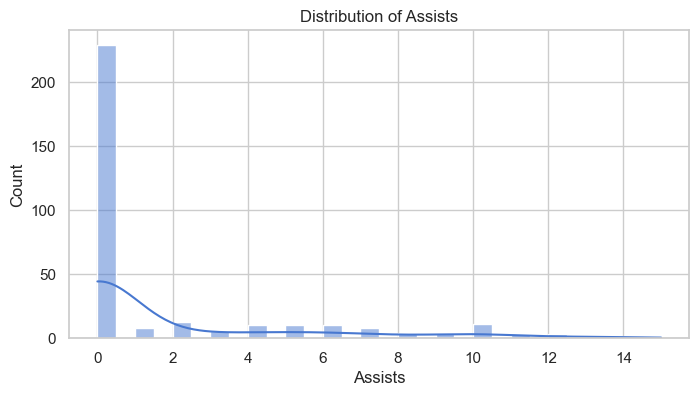

Top 10 players by assists:


,Player,Assists
57,Eden Hazard,15.0
144,Frank Lampard,14.0
30,Harry Kane,14.0
20,Mohamed Salah,13.0
3,Ollie Watkins,13.0
100,Luis Suárez,12.0
32,Bruno Fernandes,12.0
13,Mohamed Salah,12.0
1,Cole Palmer,11.0
129,Emmanuel Adebayor,11.0


In [9]:
# Step 8: target check
# Find best candidate column for assists
assist_col = None
for candidate in ['Assists','assists','ASSISTS']:
    if candidate in df.columns:
        assist_col = candidate
        break
if assist_col is None:
    raise KeyError("No Assists column found. Check column names: " + ", ".join(df.columns))

# distribution
plt.figure(figsize=(8,4))
sns.histplot(df[assist_col], bins=30, kde=True)
plt.title("Distribution of Assists")
plt.xlabel("Assists")
plt.show()

# Top 10 players by assists
for col in ['Player','player','Name']:
    if col in df.columns:
        name_col = col
        break
else:
    name_col = None

if name_col:
    top10 = df.sort_values(by=assist_col, ascending=False).head(10)[[name_col, assist_col]]
    print("Top 10 players by assists:")
    display(top10)
else:
    print("No player-name column found to show top players.")


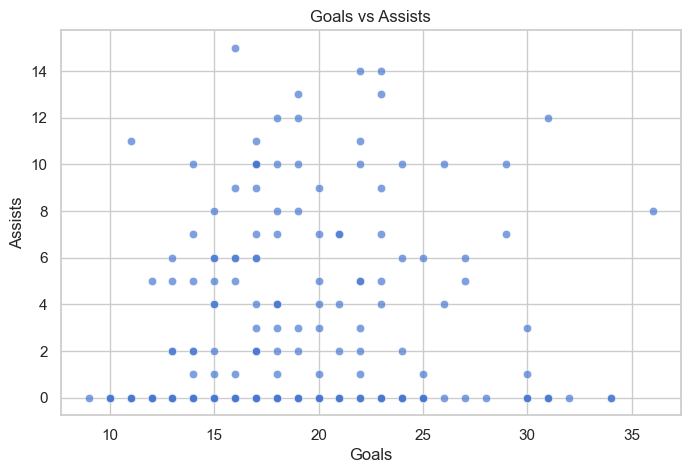

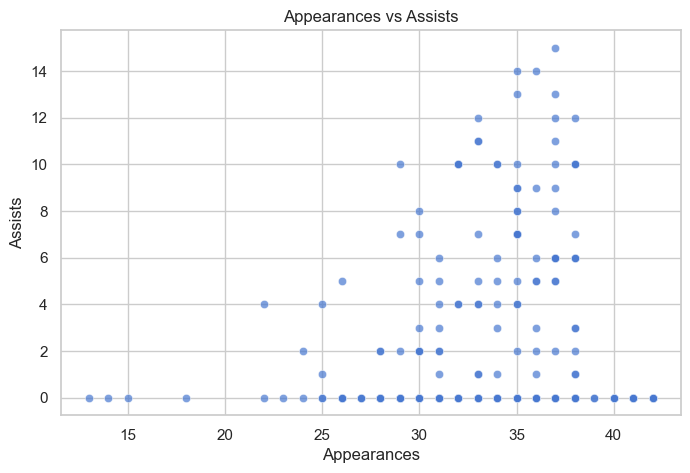

In [10]:
# Step 9: scatter plots
plt.figure(figsize=(8,5))
if 'Goals' in df.columns:
    sns.scatterplot(x='Goals', y=assist_col, data=df, alpha=0.7)
    plt.title("Goals vs Assists")
    plt.show()
else:
    print("No 'Goals' column found, skipping Goals vs Assists")

if 'Appearances' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='Appearances', y=assist_col, data=df, alpha=0.7)
    plt.title("Appearances vs Assists")
    plt.show()


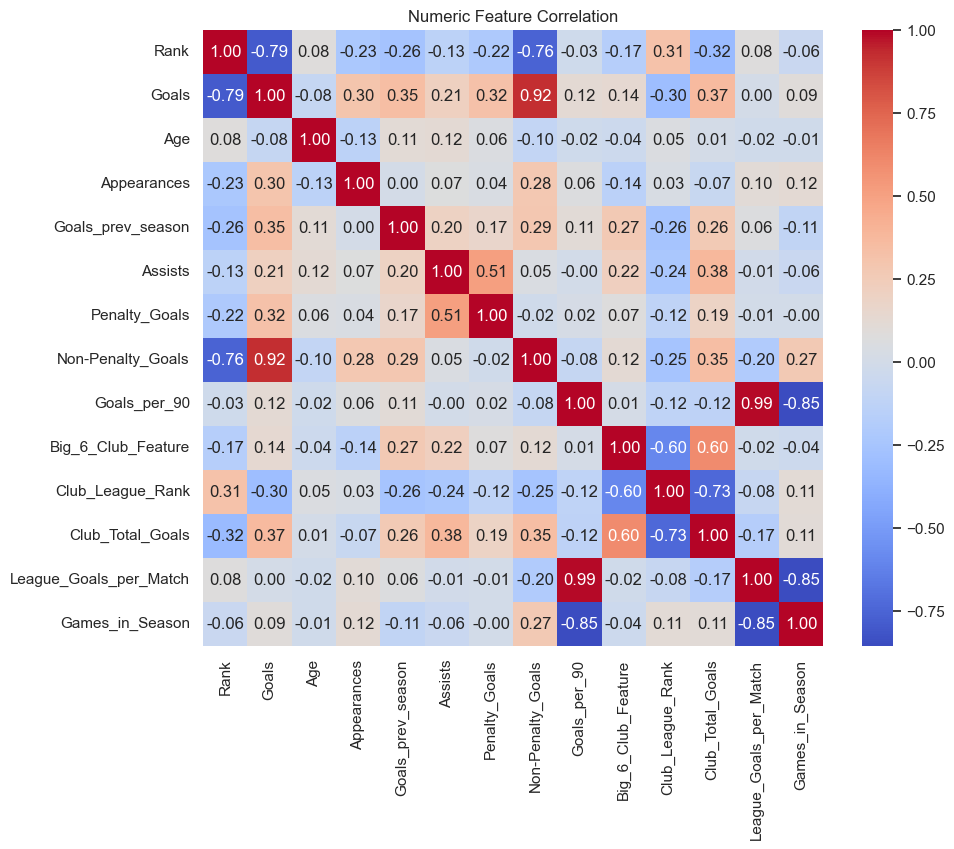

Top correlations with assists:
Assists               1.000000
Penalty_Goals         0.508275
Club_Total_Goals      0.378119
Big_6_Club_Feature    0.221972
Goals                 0.213902
Goals_prev_season     0.199340
Age                   0.122562
Appearances           0.066696
Non-Penalty_Goals     0.045855
Goals_per_90         -0.002072
Name: Assists, dtype: float64


In [11]:
# Step 10: numeric correlation
num = df.select_dtypes(include=[np.number])
corr = num.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Feature Correlation")
plt.show()

# show correlation of features with Assists
if assist_col in corr.index:
    print("Top correlations with assists:")
    print(corr[assist_col].sort_values(ascending=False).head(10))


In [12]:
# Step 11: feature engineering
df_fe = df.copy()

# create goals_per_game, assists_per_game if columns exist
if 'Appearances' in df_fe.columns:
    for base_col in ['Goals','Assists']:
        if base_col in df_fe.columns:
            new_col = base_col + '_per_game'
            df_fe[new_col] = df_fe[base_col] / df_fe['Appearances']
            print("Created", new_col)

# If goals_per_90 exists use it; otherwise compute if Minutes column exists
if 'Minutes' in df_fe.columns and 'Assists' in df_fe.columns:
    df_fe['Assists_per_90'] = df_fe['Assists'] / (df_fe['Minutes'] / 90)
    print("Created Assists_per_90 from Minutes")

df_fe.head()


Created Goals_per_game
Created Assists_per_game


,Season,Rank,Player,Team,Goals,Position,Age,Appearances,Goals_prev_season,Assists,Penalty_Goals,Non-Penalty_Goals,Goals_per_90,Big_6_Club_Feature,Club_League_Rank,Club_Total_Goals,League_Goals_per_Match,Games_in_Season,Goals_per_game,Assists_per_game
0,2023-24,1,Erling Haaland,Manchester City,27,Forward,23,31,36.0,6.0,1.0,26,0.85,1.0,1,96,2.83,38.0,0.870968,0.193548
1,2023-24,2,Cole Palmer,Chelsea,22,Attacking Midfielder,22,33,3.0,11.0,9.0,13,0.61,1.0,6,77,2.83,38.0,0.666667,0.333333
2,2023-24,3,Alexander Isak,Newcastle United,21,Forward,24,30,10.0,2.0,5.0,16,0.76,0.0,7,85,2.83,38.0,0.700000,0.066667
3,2023-24,4,Ollie Watkins,Aston Villa,19,Forward,28,37,15.0,13.0,0.0,19,0.51,0.0,4,76,2.83,38.0,0.513514,0.351351
4,2023-24,4,Dominic Solanke,AFC Bournemouth,19,Forward,26,38,6.0,3.0,1.0,18,0.50,0.0,12,54,2.83,38.0,0.500000,0.078947


In [13]:
# Step 12: label encode Team/Club (simple approach)
df_enc = df_fe.copy()
club_col = None
for c in ['Team','team','Club','club']:
    if c in df_enc.columns:
        club_col = c
        break

if club_col:
    le_club = LabelEncoder()
    df_enc['club_encoded'] = le_club.fit_transform(df_enc[club_col])
    print("Club encoding example:", dict(zip(le_club.classes_[:10], le_club.transform(le_club.classes_[:10]))))
else:
    print("No team/club column found; skipping club encoding")


Club encoding example: {'AFC Bournemouth': 0, 'Arsenal': 1, 'Aston Villa': 2, 'Birmingham City': 3, 'Blackburn Rovers': 4, 'Blackpool': 5, 'Bolton Wanderers': 6, 'Brentford': 7, 'Charlton Athletic': 8, 'Chelsea': 9}


In [14]:
# Step 13: prepare X and y
df_model = df_enc.copy()

# identify target column (assists)
y_col = assist_col

# candidate features: numeric columns excluding the target
X = df_model.select_dtypes(include=[np.number]).copy()
if y_col in X.columns:
    X = X.drop(columns=[y_col])
else:
    # defensive
    print("Warning: target not numeric or not present in numeric selection")

y = df_model[y_col]

print("Final feature columns:", X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)


Final feature columns: ['Rank', 'Goals', 'Age', 'Appearances', 'Goals_prev_season', 'Penalty_Goals', 'Non-Penalty_Goals', 'Goals_per_90', 'Big_6_Club_Feature', 'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match', 'Games_in_Season', 'Goals_per_game', 'Assists_per_game', 'club_encoded']
X shape: (324, 16) y shape: (324,)


In [15]:
# Step 14: baseline predictor
from sklearn.dummy import DummyRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline (mean) MAE:", mean_absolute_error(y_test, y_pred_dummy))
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dummy)))
print("Baseline R2:", r2_score(y_test, y_pred_dummy))


Baseline (mean) MAE: 2.953727353727354
Baseline RMSE: 4.119818852890184
Baseline R2: -0.0305310505440628


In [16]:
# Step 15: linear regression pipeline
from sklearn.pipeline import Pipeline

num_features = X.columns.tolist()

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))


Linear Regression MAE: 0.19225846618239953
Linear Regression RMSE: 0.37505384272532766
Linear Regression R2: 0.9914593272873233


RF MAE: 0.21338461538461542
RF RMSE: 0.5443803817185187
RF R2: 0.9820067434541431
Top feature importances:


Assists_per_game          0.991874
Appearances               0.001935
Club_League_Rank          0.000636
Non-Penalty_Goals         0.000631
Goals                     0.000630
Goals_prev_season         0.000614
Penalty_Goals             0.000590
Goals_per_90              0.000550
Goals_per_game            0.000539
club_encoded              0.000518
Age                       0.000417
Rank                      0.000417
Club_Total_Goals          0.000341
League_Goals_per_Match    0.000222
Big_6_Club_Feature        0.000086
Games_in_Season           0.000000
dtype: float64

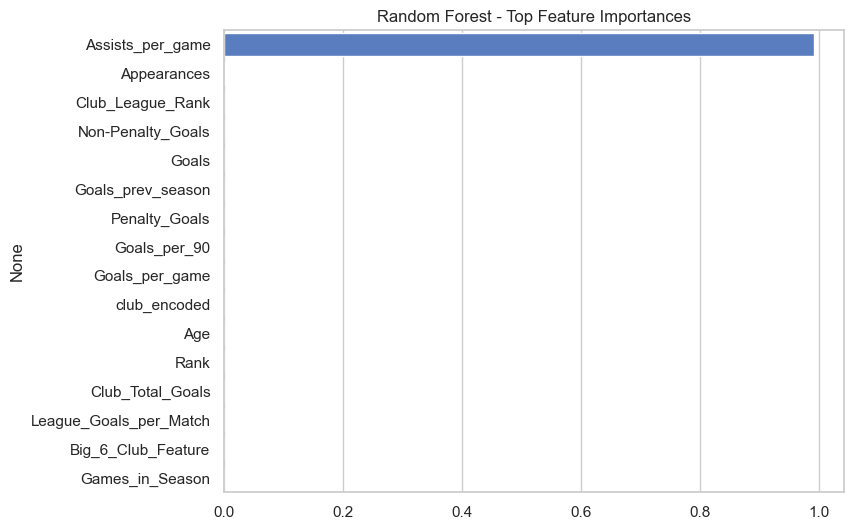

In [17]:
# Step 16: Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("RF R2:", r2_score(y_test, y_pred_rf))

# feature importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
print("Top feature importances:")
display(feat_imp)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest - Top Feature Importances")
plt.show()


In [18]:
# Step 17: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=300, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("GB MAE:", mean_absolute_error(y_test, y_pred_gb))
print("GB RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("GB R2:", r2_score(y_test, y_pred_gb))


GB MAE: 0.0928573447069309
GB RMSE: 0.2801790499095024
GB R2: 0.9952337572567096


In [19]:
# Step 18: cross-validation
models_cv = {
    'Linear': pipeline_lr,
    'RandomForest': rf,
    'GradientBoosting': gb
}

for name, model in models_cv.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    scores = -scores  # make positive MAE
    print(f"{name} CV MAE (5-fold): mean={scores.mean():.4f}, std={scores.std():.4f}")


Linear CV MAE (5-fold): mean=0.3285, std=0.1858
RandomForest CV MAE (5-fold): mean=0.1552, std=0.1927
GradientBoosting CV MAE (5-fold): mean=0.1123, std=0.1399


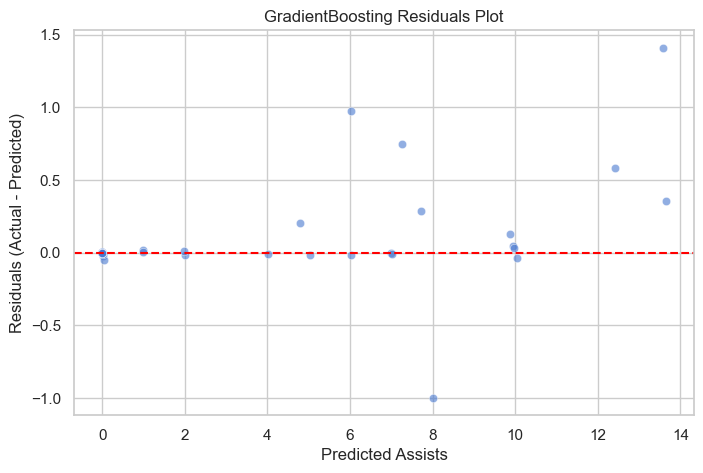

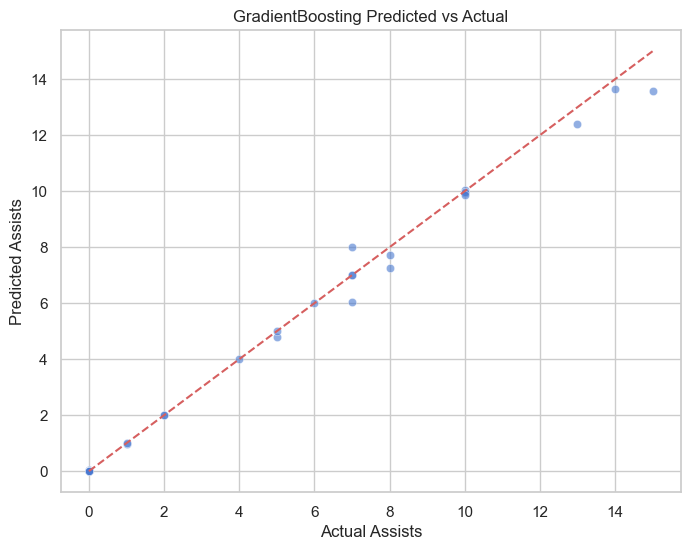

In [20]:
# Step 19: residuals for best model (choose rf or gb based on earlier)
best_pred = y_pred_gb  # switch to y_pred_rf if RF was better
model_name = "GradientBoosting" if best_pred is y_pred_gb else "RandomForest"

residuals = y_test - best_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=best_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Assists")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"{model_name} Residuals Plot")
plt.show()

# predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Assists")
plt.ylabel("Predicted Assists")
plt.title(f"{model_name} Predicted vs Actual")
plt.show()


In [22]:
#  save
os.makedirs("models", exist_ok=True)

# choose final model based on metrics; here we choose gb as example
final_model = gb
joblib.dump(final_model, "models/top_scorer_assists_regressor.joblib")
print("Saved final model to models/top_scorer_assists_regressor.joblib")

# Final summary printout
print("\n--- Final Summary ---")
print("Baseline MAE:", mean_absolute_error(y_test, y_pred_dummy))
print("Linear MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("GB MAE:", mean_absolute_error(y_test, y_pred_gb))
print("\nNotes: Choose the model with lowest MAE and acceptable R2.\n")
print("Next steps: hyperparameter tuning (GridSearchCV), add more features (player minutes, passes, xA), or use stacking.")


Saved final model to models/top_scorer_assists_regressor.joblib

--- Final Summary ---
Baseline MAE: 2.953727353727354
Linear MAE: 0.19225846618239953
RF MAE: 0.21338461538461542
GB MAE: 0.0928573447069309

Notes: Choose the model with lowest MAE and acceptable R2.

Next steps: hyperparameter tuning (GridSearchCV), add more features (player minutes, passes, xA), or use stacking.
